<a href="https://colab.research.google.com/github/AABNassim/DPPML/blob/master/permafrost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### read this first ###
## please save a copy of this notebook in your own drive!








## File > Save Copy in Drive





























# Thank you :)

# Permafrost & polygonal ground
Permafrost is, per definition, a subsurface phenomenon. So how can we observe it with remote sensing? 

--> Luckily, (thawing) permafrost landscapes exhibit very characteristic features at the Earth's surface and thus allow us to observe what's happening below.

One of these features is polygonal-patterned ground, which becomes visible in very ice-rich permafrost characterized by elaborate ice-wedge networks in the ground. Depending on the state of permafrost degradation, we can either observe low-centered polygons (intact permafrost) or high-centered polygons (thawing permafrost).




![](https://drive.google.com/uc?export=view&id=1E_kQDwWr1-tUWpP8LMznkkOIAr8RrvHG)

In this tutorial, we will deploy a simple CNN to segment these polygons from high-resolution aerial imagery.

Most of the code and data was prepared by Luisa Wagner during her internship at the Permafrost Research Section of the Alfred Wegener Institute.


For the segmentation, we will be using the detectron2 library, which is based on Mask-RCNN. You can find more info here: https://github.com/facebookresearch/detectron2

**Before we start: Make sure GPU runtime is enabled. For this, in the menu, go to: Runtime > change runtime > select GPU > ok.**

As detectron2 is not compatible with the newest Pytorch or cuda versions, we'll need to downgrade those first.

In [ ]:
# let's make sure that all our packages are compatible with our python and torch versions :) - this may take 2-3 minutes

!pip install -qq pyyaml==5.1
!pip uninstall -y torchaudio torchtext  # Remove these as we don't need them but they will mess up our dependencies
# CUDA 11.1 (need to downgrade for detectron2-compatibility)
!pip install -qq torch==1.10.0+cu111 torchvision==0.11.0+cu111 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
!pip install -qq detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Found existing installation: torchaudio 0.13.1+cu116
Uninstalling torchaudio-0.13.1+cu116:
  Successfully uninstalled torchaudio-0.13.1+cu116
Found existing installation: torchtext 0.14.1
Uninstalling torchtext-0.14.1:
  Successfully uninstalled torchtext-0.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 GB 703.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 75.6 MB/s eta 0:00:00
torch:  1.10 ; cuda:  cu111
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 5.4 MB/s eta 0:00:00
     ━━━━

In [ ]:
# and now for all the other libraries:
# common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
%matplotlib inline

# detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

# import data from google drive
from google.colab import drive

Under the following link you'll find some testing images (you'll see that they are similar to the training images), and the pre-trained model. Let's download the archive, unzip it, and mount it to the Colab.

In [ ]:
!wget https://transfer.sh/UOuVg4/polygons-data_ws.zip
!unzip -q polygons-data_ws.zip

--2023-02-14 13:30:58--  https://transfer.sh/UOuVg4/polygons-data_ws.zip
Resolving transfer.sh (transfer.sh)... 144.76.136.153, 2a01:4f8:200:1097::2
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 399340301 (381M) [application/zip]
Saving to: ‘polygons-data_ws.zip’

polygons-data_ws.zi 100%[===================>] 380.84M  20.3MB/s    in 28s     

2023-02-14 13:31:26 (13.8 MB/s) - ‘polygons-data_ws.zip’ saved [399340301/399340301]



In [ ]:
# and then set the image location (google drive)
root_dir = "/content/polygons-data_ws"

If the zip-download doesn't work for you, follow this link manually: https://transfer.sh/UOuVg4/polygons-data_ws.zip, download the zip-archive and upload it to your Google Drive. Then uncomment the following cell and run it.

In [ ]:
# # mount your google drive
# drive.mount('/content/gdrive/', force_remount=True)
# # a window should pop up, asking you for permission to connect.

# # set image location (google drive)
# root_dir = "/content/gdrive/MyDrive/polygons-data_ws"

Mounted at /content/gdrive/


We have previously labeled 600 images and trained a model (as this takes ca. 30 minutes). To speed things up for this workshop, we provide you with that model in the subfolder "/model".

Here are some examples of what our training data looked like:
![](https://drive.google.com/uc?export=view&id=1BHJzjtTestv6hBLFy8LgbQPA1E7OK6eU)

So let's go ahead and load the pre-trained model. The basis for our model was also a pre-trained Mask-RCNN, that we used to transfer-learn on. So we'll first load the basic architecture from the model zoo.

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.OUTPUT_DIR = root_dir + "/model"
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # training initializes from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 1000    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.INPUT.RANDOM_FLIP="none"
cfg.INPUT.MIN_SIZE_TEST = 0
cfg.INPUT.MIN_SIZE_TRAIN = 0
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0

And now we'll import our weights from the model that we further trained on the images of polygons.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set a testing threshold
predictor = DefaultPredictor(cfg)

Once the model is successfully loaded, we can already go ahead and predict on some unseen data. 
The folder *polygon_tiles* has a few images that were not used for training. 
Run the following cell a few times. 

> **What do you observe?**



<Figure size 1080x504 with 0 Axes>

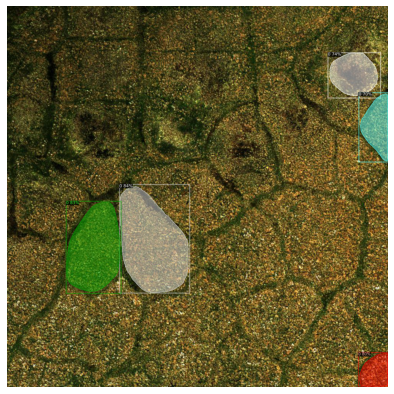

In [ ]:
# predict full image
plt.figure(figsize=(15,7))
for img in random.sample(os.listdir(root_dir + "/polygon_tiles/"), 1):
    im = cv2.imread(root_dir + "/polygon_tiles/" + img)
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])
    plt.axis("off")

What if we play around with the prediction threshold (two cells up)?